# 1. 逻辑回归多分类任务 识别手写数字

## 1.1 数据可视化

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import pandas as pd
from scipy.io import loadmat

In [2]:
data = loadmat('ex3data1.mat')
print(type(data))
X = data['X']
y = data['y']
X.shape, y.shape

<class 'dict'>


((5000, 400), (5000, 1))

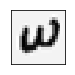

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1)) #1.1代表几行几列， 当有多个图的时候要用ax0, ax1 ... = ax.ravel()函数分别进行画图
ax.matshow(X[1500,:].reshape(20, 20), cmap=matplotlib.cm.binary)
plt.xticks([])
plt.yticks([]) #取消刻度
plt.show()

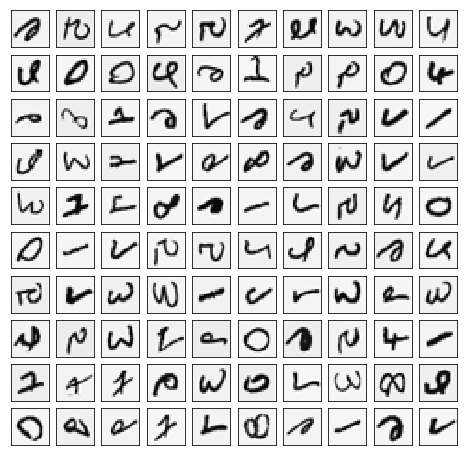

In [4]:
for i in range(100):
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100) #在0-4999中选100个值,返回一个数组
    image = X[sample_idx,:]

fig, axes = plt.subplots(10, 10,sharey=True, sharex=True, figsize=(8, 8))

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(image[i * 10 + j].reshape((20, 20)), cmap=matplotlib.cm.binary)

        
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.show()

## 1.2 多分类任务

In [5]:
def sigmoid(z):
    #theta为列向量
    return 1. / (1 + np.exp(-z))

带正则化项的向量化损失函数

In [6]:
def cost(theta, X, y, labmda):
    m = len(y)
    theta = theta.reshape(theta.shape[0], 1)
    h = sigmoid(np.dot(X, theta))
    J = -1. / m * np.sum(np.multiply(y, np.log(h)) + np.multiply(1 - y, np.log(1 - h))) #损失函数最开始写错了，成了1 - log，已经修正
    reg = labmda / (2*m) * np.sum(np.power(theta[1:], 2)) #不对theta0使用罚项，差点出错了
    return J + reg

In [7]:
def gradient(theta, X, y, labmda):
    m = len(y)
    theta = theta.reshape(theta.shape[0], 1) #theta为（n,）所以需要扩到二维
    h = sigmoid(np.dot(X, theta))
    updates = 1. / m *  np.dot(X.T, h-y)
    reg = labmda / m * theta
    reg[0, 0] = 0 #不对theta0使用罚项
    return (updates + reg).squeeze()

开始执行多分类任务

In [8]:
from scipy.optimize import minimize
import scipy.optimize as opt

def one_vs_all(X, y, num_labels, labmda):
    rows = len(y)
    cols = X.shape[1]
    
    all_theta = np.zeros((num_labels, cols+1)) #存储这10个类别的分类器的最终theta的值
    X = np.insert(X, 0, values=np.ones(rows), axis=1) #axis=1代表第二维 index = 0，第一列
    
    for i in range(1, num_labels+1):
        theta = np.zeros(cols+1)
        y_i = np.array([1 if j == i else 0 for j in y])
        y_i = y_i.reshape(rows, 1)
#         fmin = minimize(fun=cost, x0=theta, args=(X, y_i, labmda), method='TNC', jac=gradient) #两者结果一样
        fmin = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y_i, labmda))
        all_theta[i-1, :] = fmin[0]
#         all_theta[i-1, :] = fmin.x

    return all_theta

In [9]:
all_theta = one_vs_all(X, y, 10, 1)
all_theta

array([[-2.38168425e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30419975e-03, -7.06040881e-10,  0.00000000e+00],
       [-3.18517861e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45741822e-03, -5.08200807e-04,  0.00000000e+00],
       [-4.79801670e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.88148348e-05, -2.48173419e-07,  0.00000000e+00],
       ...,
       [-7.98784355e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94916966e-05,  7.21374474e-06,  0.00000000e+00],
       [-4.57234977e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33790200e-03,  1.00158331e-04,  0.00000000e+00],
       [-5.40550556e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16517940e-04,  7.86067006e-06,  0.00000000e+00]])

## 1.3 准确率

In [10]:
def prediction(X, all_theta):
    rows = X.shape[0]
    cols = X.shape[1]
    
    X = np.insert(X, 0, np.ones(rows), axis=1)
    predict = sigmoid(np.dot(X, all_theta.T))  #向量化
    
    return predict.argmax(axis=1) + 1 #argmax返回的是最大的那个值的下标， 而下标+1就是类别

In [11]:
predict = prediction(X, all_theta)
predict = predict.reshape(predict.shape[0], 1)
predict = predict[predict == y]
print("Accuracy is " + str(len(predict) / len(y) * 100) + '%')

Accuracy is 94.46%


这个答案与文档中的答案已经比较接近，猜测是由于优化方式不同所导致的误差

# 神经网络

## 1.1 导入数据

In [12]:
weight = loadmat('ex3weights.mat')
theta1 = weight['Theta1']
theta2 = weight['Theta2']
print(theta1.shape, theta2.shape)

(25, 401) (10, 26)


## 1.2 前向传播

In [13]:
def forward(X, theta1, theta2):
    X = np.insert(X, 0, np.ones(X.shape[0]), axis=1) # X = a0
    z1 = np.dot(X, theta1.T)
    a1 = sigmoid(z1)
    a1 = np.insert(a1, 0, values=np.ones(a1.shape[0]), axis=1)
    z2 = np.dot(a1, theta2.T)
    a2 = sigmoid(z2)

    return a2

## 1.3准确率

In [14]:
predict = forward(X, theta1, theta2)
predict = predict.argmax(axis=1) + 1
predict = predict.reshape(predict.shape[0], 1)
predict = predict[predict == y]
print("Accuracy is " + str(len(predict) / len(y) * 100) + "%")

Accuracy is 97.52%
